In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import smogn
import time
import optuna
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer
from joblib import dump, load
from scipy.stats import shapiro
from scipy.stats import ttest_rel
from scipy.stats import levene
from sklearn.model_selection import learning_curve

In [13]:
selected_features = ['seller_id', 'product_like_count_sum', 'price_usd_max',
       'seller_price_mean', 'seller_earning_sum', 'seller_products_sold',
       'seller_community_rank', 'seller_num_followers', 'sold', 'in_stock',
       'avg_product_name_length', 'avg_product_keywords_length',
       'products_listed_to_sold_ratio', 'product_type_most_common_target_enc',
       'brand_name_most_common_target_enc', 'seller_country_target_enc',
       'seller_badge_Expert', 'seller_badge_Trusted',
       'usually_ships_within_most_common_3-5 days',
       'usually_ships_within_most_common_unknown']


In [14]:
# Load training and test sets
X_train_original = pd.read_csv("X_train.csv")[selected_features]  # Apply selected features
y_train_original = pd.read_csv("y_train.csv").squeeze()
X_test = pd.read_csv("X_test.csv")[selected_features]    # Apply selected features
y_test = pd.read_csv("y_test.csv").squeeze()

In [6]:
# Combine selected features with the target column
train_data = X_train_original.copy()
train_data['seller_pass_rate'] = y_train_original

In [7]:
train_data.shape

(113157, 21)

In [13]:
smogn = smogn.smoter(
    data=train_data,
    y='seller_pass_rate',  # Target variable
    samp_method='balance',  # Balancing strategy
    rel_thres=0.4,  # Relevance threshold to keep consistent
    k=2,  # Same number of neighbors as SMOTER
    rel_method='auto',  # Automatic relevance method for consistency
    pert=0.02, # Low perturbation to reduce noise
)


# Separate the features and target after SMOGN
X_train_smogn = smogn.drop(columns=['seller_pass_rate'])
y_train_smogn = smogn['seller_pass_rate']

r_index: 100%|##########| 5010/5010 [00:10<00:00, 461.91it/s]


In [ ]:
# Renamimg X_train_smogn and y_train_smogn
X_train = X_train_smogn
y_train = y_train_smogn

In [15]:
smogn.to_csv('smogn_data.csv', index=False)

In [15]:
smogn_data = pd.read_csv("smogn_data.csv")

In [16]:
# Separate the features (X_train) and target variable (y_train)
X_train = smogn_data.drop(columns=["seller_pass_rate"])
y_train = smogn_data["seller_pass_rate"]

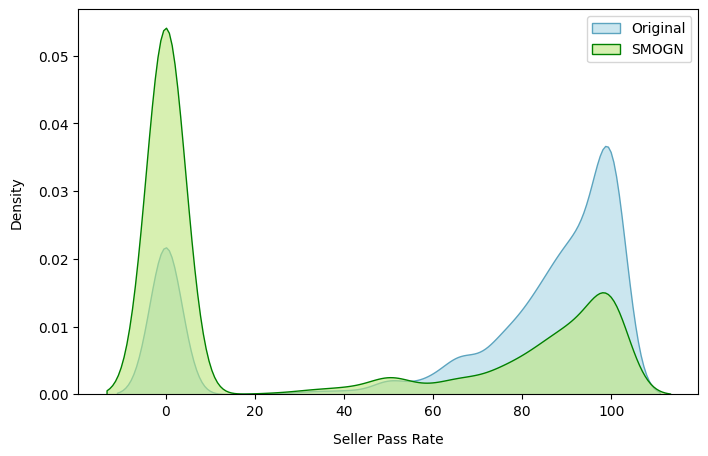

In [78]:
plt.figure(figsize=(8, 5))

# Plot both distributions on the same figure
sns.kdeplot(y_train_original, color='#A9D6E5', label="Original", edgecolor='#5CA4BF', fill=True, alpha=0.6)
#sns.kdeplot(smogn_data["seller_pass_rate"], color='green', label="SMOGN", fill=True, alpha=0.3)
sns.kdeplot(y_train, color='#BDE77E', label="SMOGN", edgecolor='green', fill=True, alpha=0.6)


# Set titles and labels
#plt.title("Target Variable Density Before and After SMOGN", fontweight='bold')
plt.xlabel("Seller Pass Rate", labelpad=10)
plt.ylabel("Density", labelpad=10)
plt.ylim()

# Add a legend and display the plot
plt.legend()
plt.show()


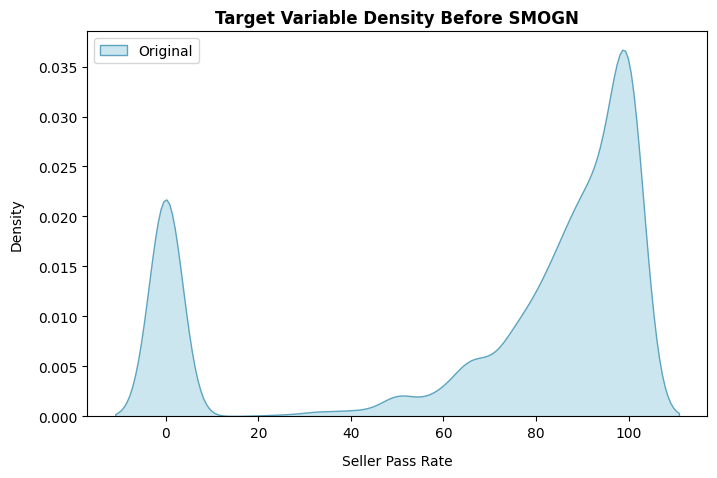

In [72]:
# Define consistent y-axis limits
#y_axis_limit = (0, 0.06)  # Adjust based on your data

# Plot the original dataset distribution
plt.figure(figsize=(8, 5))
sns.kdeplot(y_train_original, fill=True, color='#A9D6E5', edgecolor='#5CA4BF', label='Original', alpha=0.6)
#plt.ylim(y_axis_limit)
plt.xlabel("Seller Pass Rate", labelpad=10)
plt.ylabel("Density", labelpad=10)
plt.title("Target Variable Density Before SMOGN", fontweight='bold')
plt.legend(loc='upper left')
plt.show()

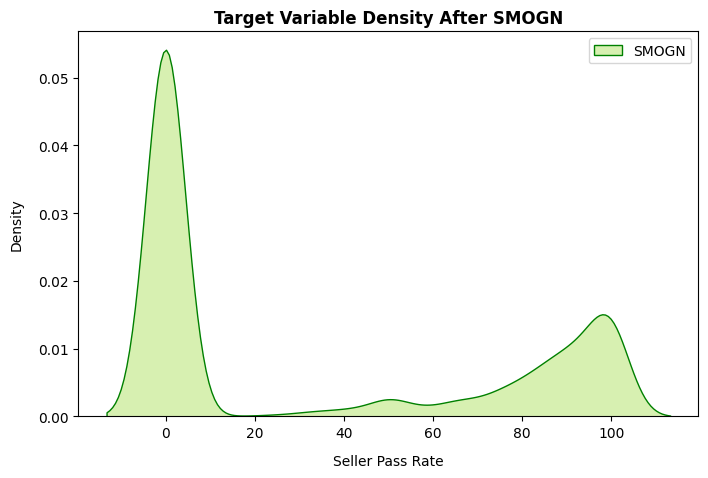

In [73]:
# Plot the SMOGN dataset distribution
plt.figure(figsize=(8, 5))
sns.kdeplot(y_train, fill=True, color='#BDE77E', edgecolor='green', label='SMOGN', alpha=0.6)
#plt.ylim(y_axis_limit)
plt.xlabel("Seller Pass Rate", labelpad=10)
plt.ylabel("Density", labelpad=10)
plt.title("Target Variable Density After SMOGN", fontweight='bold')
plt.legend()
plt.show()

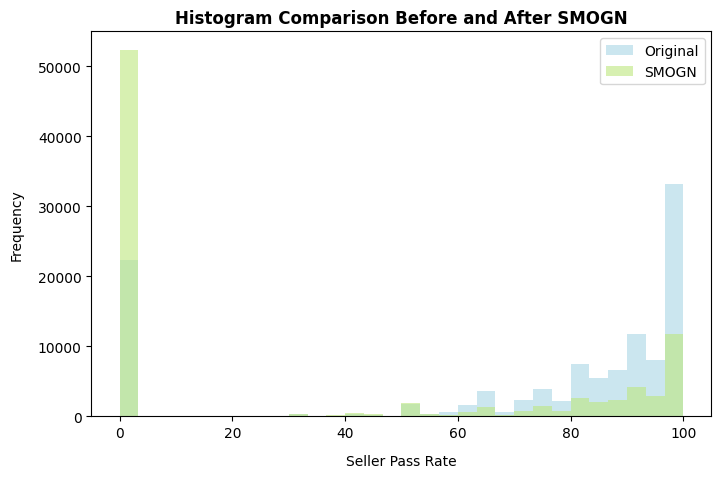

In [74]:
plt.figure(figsize=(8, 5))
plt.hist(y_train_original, bins=30, alpha=0.6, label="Original", color='#A9D6E5')
plt.hist(y_train, bins=30, alpha=0.6, label="SMOGN", color='#BDE77E')
plt.title("Histogram Comparison Before and After SMOGN", fontweight="bold")
plt.xlabel("Seller Pass Rate", labelpad=10)
plt.ylabel("Frequency", labelpad=10)
plt.legend()
plt.show()

Training Models

1. Linear Regression

In [20]:
metrics = {} 

In [21]:

# Initialize Linear Regression with default parameters
model = LinearRegression()

# Define MAE as the scoring metric
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate the model using cross-validation and calculate fold-wise MAE scores
cv_mae = -cross_val_score(model, X_train, y_train, cv=kf, scoring=mae_scorer, n_jobs=-1)

# Print fold-wise MAE scores
print("Fold-wise MAE scores for Linear Regression:", cv_mae)

# Store fold-wise MAE scores in the metrics dictionary
metrics['Linear Regression'] = cv_mae.tolist()

# Print the metrics dictionary (optional)
print("Updated Metrics Dictionary:", metrics)

# Compute Learning Curve
train_sizes, train_scores, cv_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 evenly spaced sizes
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

# Store learning curve data (convert negative MAE to positive)
learning_curve_data = {
    'train_sizes': train_sizes,
    'train_scores_mean': -train_scores.mean(axis=1),
    'train_scores_std': train_scores.std(axis=1),
    'cv_scores_mean': -cv_scores.mean(axis=1),
    'cv_scores_std': cv_scores.std(axis=1)
}

# Print Learning Curve Data Ready message
print("Learning Curve Data Ready")


Fold-wise MAE scores for Linear Regression: [26.37405731 26.24358982 26.31795463 26.22324314 26.34988783]
Updated Metrics Dictionary: {'Linear Regression': [26.374057312292315, 26.24358982237618, 26.317954629705334, 26.223243137108483, 26.34988783423478]}
Learning Curve Data Ready


In [22]:
final_lr_model = LinearRegression()

# Measure training time
start_time = time.time()
final_lr_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Save the trained Random Forest Regressor model
lr_imb_path = "lr_smogn.pkl"
dump(final_lr_model, lr_imb_path)
print(f"Linear Regression model saved successfully to {lr_imb_path}!")

# Predict on the training set and evaluate
y_train_pred = final_lr_model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))  
train_r2 = r2_score(y_train, y_train_pred)

print("\nTraining Set Results:")
print("MAE:", train_mae)
print("RMSE:", train_rmse)
print("R²:", train_r2)
print("Training Time:", training_time, "seconds")

# Predict on the test set and evaluate
start_time = time.time()
y_pred_lr = final_lr_model.predict(X_test)
test_time = time.time() - start_time

pd.DataFrame(y_pred_lr, columns=["y_pred_lr"]).to_csv("lr_smong_predictions.csv", index=False)


test_mae = mean_absolute_error(y_test, y_pred_lr)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))
test_r2 = r2_score(y_test, y_pred_lr)

print("\nTest Set Results:")
print("MAE:", test_mae)
print("RMSE:", test_rmse)
print("R²:", test_r2)
print("Test Evaluation Time:", test_time, "seconds")

Linear Regression model saved successfully to lr_smogn.pkl!

Training Set Results:
MAE: 26.285904264347838
RMSE: 32.68119533360436
R²: 0.4213648404344299
Training Time: 0.04743599891662598 seconds

Test Set Results:
MAE: 33.56461132198326
RMSE: 41.00727614168293
R²: -0.20788399849256467
Test Evaluation Time: 0.004569053649902344 seconds


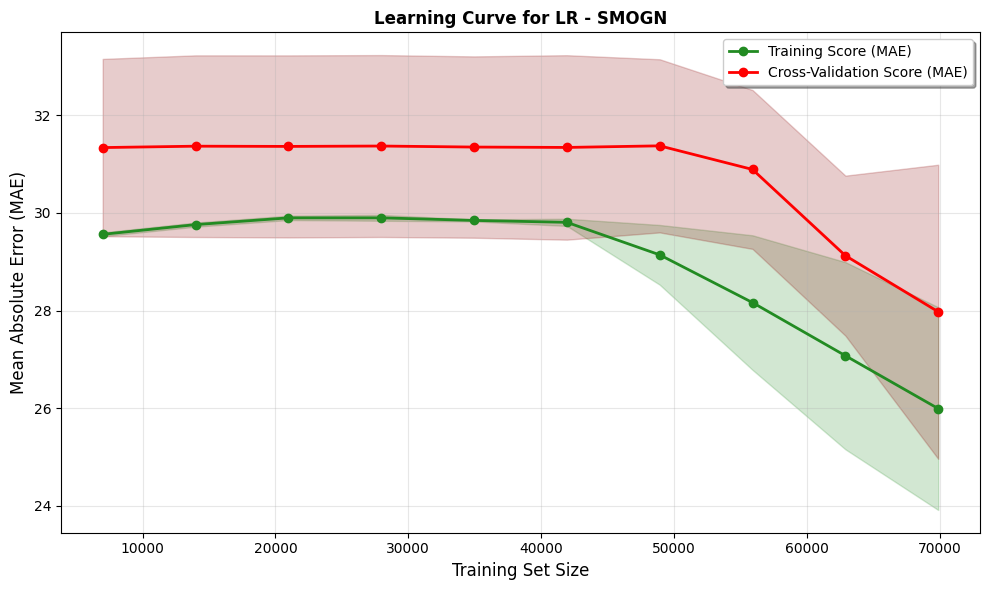

In [23]:
# Plot the learning curve

plt.figure(figsize=(10, 6))

# Plot training scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['train_scores_mean'], 
    'o-', color='#228B22', label="Training Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['train_scores_mean'] - learning_curve_data['train_scores_std'],
    learning_curve_data['train_scores_mean'] + learning_curve_data['train_scores_std'],
    alpha=0.2, color='#228B22'
)

# Plot cross-validation scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['cv_scores_mean'], 
    'o-', color='red', label="Cross-Validation Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['cv_scores_mean'] - learning_curve_data['cv_scores_std'],
    learning_curve_data['cv_scores_mean'] + learning_curve_data['cv_scores_std'],
    alpha=0.2, color='#8B0000'
)

# Add labels, title, and legend
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.title("Learning Curve for LR - SMOGN", fontweight='bold')
plt.legend(loc="best", fontsize=10, frameon=True, shadow=True)
plt.grid(alpha=0.3)

# Improve spacing and add a professional touch
plt.tight_layout()
plt.show()


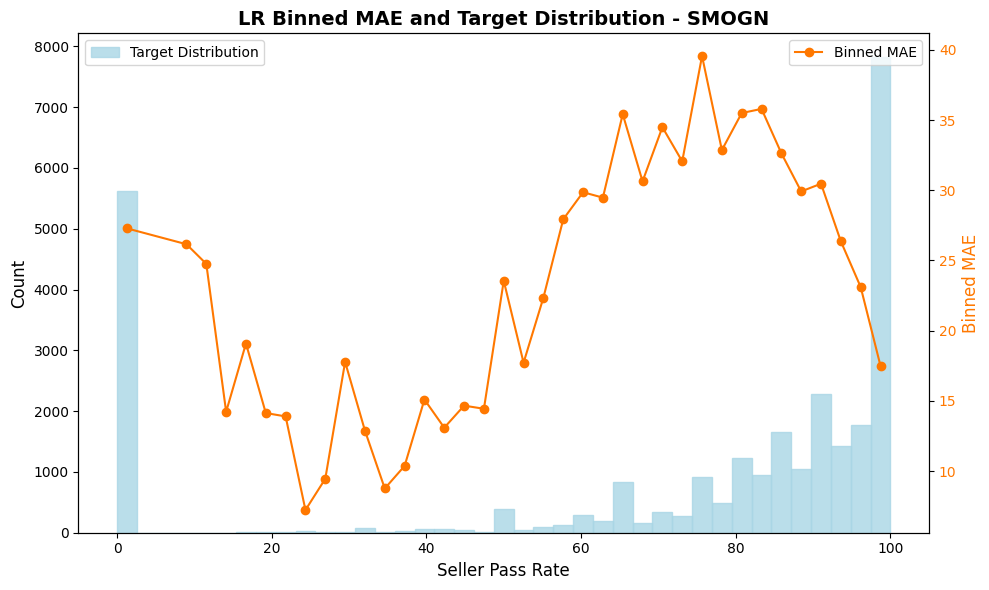

In [24]:
# Target distribution binned MAE for Linear Regression
y_pred = y_pred_lr  # Use predictions from Linear Regression

# Define bins for grouping target values
bins = np.linspace(min(y_test), max(y_test), 40)  # Adjust the number of bins if needed

# Linear Regression Binned MAE Calculation
bin_indices_lr = np.digitize(y_test, bins)  # Create bins for Linear Regression
binned_mae_lr = []
bin_centers_lr = []

for i in range(1, len(bins)):
    mask = bin_indices_lr == i
    if sum(mask) > 0:  # Only calculate MAE for bins with data
        mae = np.mean(np.abs(y_test[mask] - y_pred_lr[mask]))
        binned_mae_lr.append(mae)
        bin_centers_lr.append((bins[i - 1] + bins[i]) / 2)

# Plot Linear Regression Binned MAE
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot histogram for target distribution
ax1.hist(y_test, bins=bins, color="#A9D6E5", alpha=0.8, edgecolor="#A9D6E5", label="Target Distribution")
ax1.set_xlabel("Seller Pass Rate", fontsize=12)
ax1.set_ylabel("Count", fontsize=12, color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_title("LR Binned MAE and Target Distribution - SMOGN", fontsize=14, fontweight="bold")
ax1.legend(loc="upper left", fontsize=10)

# Add secondary y-axis for Binned MAE
ax2 = ax1.twinx()
ax2.plot(bin_centers_lr, binned_mae_lr, color="#FF7800", marker="o", linestyle="-", label="Binned MAE", linewidth=1.5)
ax2.set_ylabel("Binned MAE", fontsize=12, color="#FF7800")
ax2.tick_params(axis="y", labelcolor="#FF7800")
ax2.legend(loc="upper right", fontsize=10)

# Adjust layout and show plot
plt.tight_layout()
plt.show()



# smogn distribution? 


2. Gradient Boosting Regressor

In [25]:

# Automatically extract default hyperparameters for Gradient Boosting Regressor
default_model = GradientBoostingRegressor(random_state=42) 
default_params = default_model.get_params() 

# Filter the default hyperparameters to include only the ones being tuned
tuned_params = ['n_estimators', 'max_depth', 'learning_rate']  
filtered_defaults = {key: default_params[key] for key in tuned_params}

# Print the filtered default hyperparameters
print("Default Hyperparameters (Filtered) for Gradient Boosting Regressor:")
for key, value in filtered_defaults.items():
    print(f"{key}: {value}")

# Define the objective function for Bayesian Optimization
def objective(trial):
    # Define hyperparameters to tune (including defaults as ranges)
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=10)  # Range with step
    max_depth = trial.suggest_int('max_depth', 2, 20, step=2)  # Integer range
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, step=0.01)  # Continuous range

    # Initialize Gradient Boosting Regressor with suggested hyperparameters
    model = GradientBoostingRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        random_state=42
    )

    # Define MAE as the scoring metric
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Set up cross-validation with 5 folds and calculate MAE score
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_mae = cross_val_score(model, X_train, y_train, cv=kf, scoring=mae_scorer, n_jobs=-1)
    return -cv_mae.mean()  # Return negative MAE for minimization

# Run Optuna Bayesian Optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)  # Increase trials for final notebook run

# Retrieve the best hyperparameters
best_params = study.best_params
print("Best Parameters from Bayesian Optimization:", best_params)
print("Best Cross-Validation MAE from Bayesian Optimization:", study.best_value)

# Evaluate the best model and store fold-wise MAE scores
final_model = GradientBoostingRegressor(**best_params, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Collect fold-wise MAE scores
cv_mae = -cross_val_score(final_model, X_train, y_train, cv=kf, scoring=mae_scorer, n_jobs=-1)

# Add results to the metrics dictionary
metrics['Gradient Boosting'] = cv_mae.tolist()

# Print fold-wise scores (optional)
print("Fold-wise MAE scores for Gradient Boosting Regressor:", cv_mae)

# Compute Learning Curve
train_sizes, train_scores, cv_scores = learning_curve(
    estimator=final_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 evenly spaced sizes
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

# Store learning curve data (convert negative MAE to positive)
learning_curve_data = {
    'train_sizes': train_sizes,
    'train_scores_mean': -train_scores.mean(axis=1),
    'train_scores_std': train_scores.std(axis=1),
    'cv_scores_mean': -cv_scores.mean(axis=1),
    'cv_scores_std': cv_scores.std(axis=1)
}

# Print the metrics dictionary to verify
print("Updated Metrics Dictionary:", metrics)
print("Learning Curve Data Ready")


[I 2024-11-28 09:04:39,452] A new study created in memory with name: no-name-489152b7-a38c-4b18-93a9-2022e428701c


Default Hyperparameters (Filtered) for Gradient Boosting Regressor:
n_estimators: 100
max_depth: 3
learning_rate: 0.1


[I 2024-11-28 09:09:03,523] Trial 0 finished with value: 17.23053741629716 and parameters: {'n_estimators': 240, 'max_depth': 10, 'learning_rate': 0.8}. Best is trial 0 with value: 17.23053741629716.
[I 2024-11-28 09:12:47,391] Trial 1 finished with value: 11.655886360077183 and parameters: {'n_estimators': 180, 'max_depth': 12, 'learning_rate': 0.08}. Best is trial 1 with value: 11.655886360077183.
[I 2024-11-28 09:21:03,945] Trial 2 finished with value: 12.274411673616841 and parameters: {'n_estimators': 270, 'max_depth': 18, 'learning_rate': 0.25}. Best is trial 1 with value: 11.655886360077183.
[I 2024-11-28 09:23:59,479] Trial 3 finished with value: 13.667267237597617 and parameters: {'n_estimators': 120, 'max_depth': 14, 'learning_rate': 0.44}. Best is trial 1 with value: 11.655886360077183.
[I 2024-11-28 09:26:29,812] Trial 4 finished with value: 12.566708094524037 and parameters: {'n_estimators': 90, 'max_depth': 16, 'learning_rate': 0.29000000000000004}. Best is trial 1 with v

Best Parameters from Bayesian Optimization: {'n_estimators': 180, 'max_depth': 14, 'learning_rate': 0.03}
Best Cross-Validation MAE from Bayesian Optimization: 11.598869260518725
Fold-wise MAE scores for Gradient Boosting Regressor: [11.64361877 11.5855649  11.589389   11.59279277 11.58298087]
Updated Metrics Dictionary: {'Linear Regression': [26.374057312292315, 26.24358982237618, 26.317954629705334, 26.223243137108483, 26.34988783423478], 'Gradient Boosting': [11.643618772096028, 11.58556489843886, 11.589388996647527, 11.592792770310403, 11.582980865100808]}
Learning Curve Data Ready


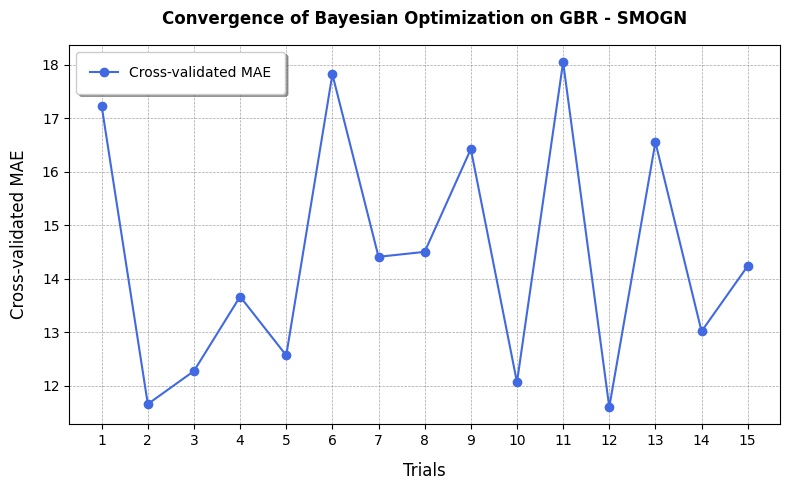

In [26]:
# Convergence Plot 


plt.figure(figsize=(8, 5))  
# Extract data from trials
trials = study.trials_dataframe()
plt.plot(
    trials.index, 
    trials['value'], 
    marker='o', 
    linestyle='-', 
    color='#4169e1',  
    label='Cross-validated MAE'
)

# Adding labels and title
plt.xlabel('Trials', fontsize=12, labelpad=10)  # Add padding for better spacing
plt.ylabel('Cross-validated MAE', fontsize=12, labelpad=10)
plt.title('Convergence of Bayesian Optimization on GBR - SMOGN', fontsize=12, pad=15, fontweight="bold")

# Ensure Trial Index is displayed as integers
plt.xticks(ticks=range(len(trials)), labels=range(1, len(trials) + 1))  # Trial indices start from 1

# Grid for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend
plt.legend(fontsize=10, loc='best', frameon=True, shadow=True, borderpad=1)

# Improve layout and show the plot
plt.tight_layout()
plt.show()


In [27]:
# Training and Testing with the Best Hyperparameters

best_params = study.best_params

# Initialize Gradient Boosting Regressor with the best parameters
final_gbr_model = GradientBoostingRegressor(**best_params, random_state=42)

# Measure training time
start_time = time.time()
final_gbr_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Save the trained Random Forest Regressor model
gbr_imb_path = "gbr_smogn.pkl"
dump(final_gbr_model, gbr_imb_path)
print(f"Gradient Boosting model saved successfully to {gbr_imb_path}!")

# Predict on the training set and evaluate
y_train_pred = final_gbr_model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))  # Root Mean Squared Error
train_r2 = r2_score(y_train, y_train_pred)

print("\nTraining Set Results with Best Parameters:")
print("MAE:", train_mae)
print("RMSE:", train_rmse)
print("R²:", train_r2)
print("Training Time:", training_time, "seconds")

# Predict on the test set and evaluate
start_time = time.time()
y_pred_gbr = final_gbr_model.predict(X_test)
test_time = time.time() - start_time

pd.DataFrame(y_pred_gbr, columns=["y_pred_gbr"]).to_csv("gbr_smogn_predictions.csv", index=False)


test_mae = mean_absolute_error(y_test, y_pred_gbr)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
test_r2 = r2_score(y_test, y_pred_gbr)

print("\nTest Set Results with Best Parameters:")
print("MAE:", test_mae)
print("RMSE:", test_rmse)
print("R²:", test_r2)
print("Test Evaluation Time:", test_time, "seconds")


Gradient Boosting model saved successfully to gbr_smogn.pkl!

Training Set Results with Best Parameters:
MAE: 6.251750466575772
RMSE: 12.042680592612701
R²: 0.92143026485789
Training Time: 372.1413230895996 seconds

Test Set Results with Best Parameters:
MAE: 17.042149431990293
RMSE: 25.923027985679646
R²: 0.5173027330331613
Test Evaluation Time: 0.6365361213684082 seconds


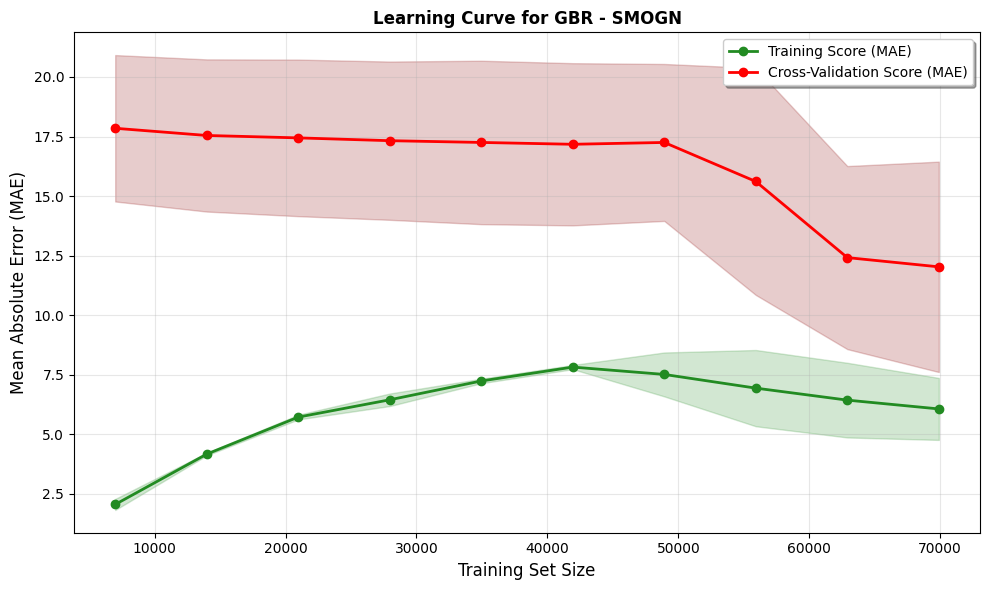

In [28]:
# Plot the learning curve

plt.figure(figsize=(10, 6))

# Plot training scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['train_scores_mean'], 
    'o-', color='#228B22', label="Training Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['train_scores_mean'] - learning_curve_data['train_scores_std'],
    learning_curve_data['train_scores_mean'] + learning_curve_data['train_scores_std'],
    alpha=0.2, color='#228B22'
)

# Plot cross-validation scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['cv_scores_mean'], 
    'o-', color='red', label="Cross-Validation Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['cv_scores_mean'] - learning_curve_data['cv_scores_std'],
    learning_curve_data['cv_scores_mean'] + learning_curve_data['cv_scores_std'],
    alpha=0.2, color='#8B0000'
)

# Add labels, title, and legend
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.title("Learning Curve for GBR - SMOGN", fontweight='bold')
plt.legend(loc="best", fontsize=10, frameon=True, shadow=True)
plt.grid(alpha=0.3)

# Improve spacing and add a professional touch
plt.tight_layout()
plt.show()


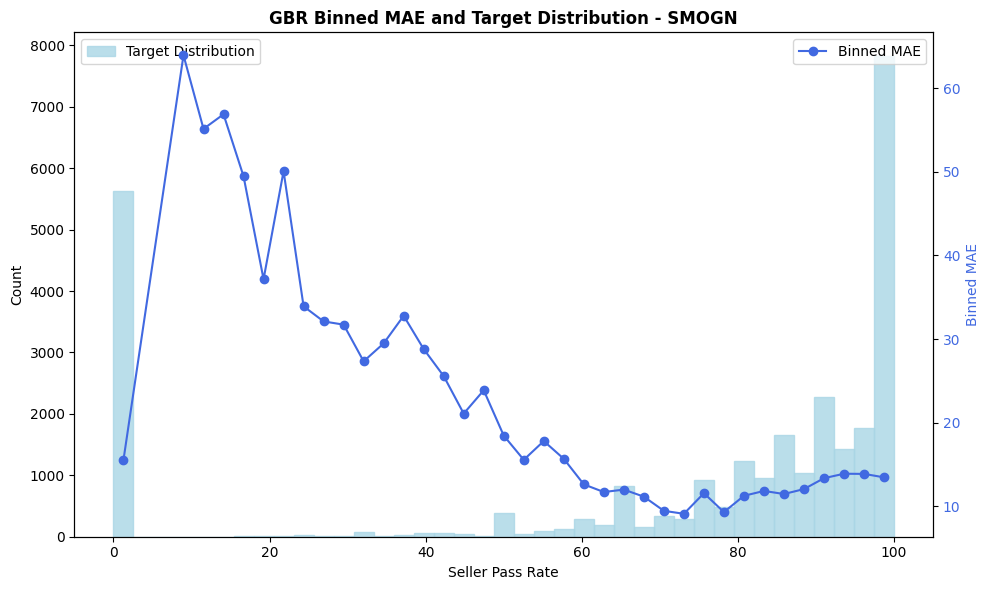

In [29]:
# target distribution binned mae

y_pred = y_pred_gbr 

# Define bins for grouping target values
bins = np.linspace(min(y_test), max(y_test), 40)

# GBR Binned MAE Calculation
bin_indices_gbr = np.digitize(y_test, bins)  # Create bins for GBR
binned_mae_gbr = []
bin_centers_gbr = []

for i in range(1, len(bins)):
    mask = bin_indices_gbr == i
    if sum(mask) > 0:
        mae = np.mean(np.abs(y_test[mask] - y_pred_gbr[mask]))
        binned_mae_gbr.append(mae)
        bin_centers_gbr.append((bins[i - 1] + bins[i]) / 2)

# Plot GBR Binned MAE
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.hist(y_test, bins=bins, color="#A9D6E5", alpha=0.8, edgecolor="#A9D6E5", label="Target Distribution")
ax1.set_xlabel("Seller Pass Rate")
ax1.set_ylabel("Count")
ax1.tick_params(axis="y", labelcolor="black")
ax1.set_title("GBR Binned MAE and Target Distribution - SMOGN", fontweight="bold")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(bin_centers_gbr, binned_mae_gbr, color="#4169e1", marker="o", linestyle="-", label="Binned MAE")
ax2.set_ylabel("Binned MAE", color="#4169e1")
ax2.tick_params(axis="y", labelcolor="#4169e1")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()   



3. Random Forest Regressor

In [30]:
# Automatically extract default hyperparameters for Random Forest Regressor
default_model = RandomForestRegressor(random_state=42)  
default_params = default_model.get_params()  

# Filter the default hyperparameters to include only the ones being tuned
tuned_params = ['n_estimators', 'max_depth', 'max_features']  
filtered_defaults = {key: default_params[key] for key in tuned_params}

# Print the filtered default hyperparameters
print("Default Hyperparameters (Filtered) for Random Forest Regressor:")
for key, value in filtered_defaults.items():
    print(f"{key}: {value}")

# Define the objective function for Bayesian Optimization
def objective(trial):
    # Define hyperparameters to tune (including defaults as ranges)
    n_estimators = trial.suggest_int('n_estimators', 50, 300, step=10)  # Range with step
    max_depth = trial.suggest_int('max_depth', 2, 20, step=2)  # Integer range
    max_features = trial.suggest_float('max_features', 0.1, 1.0)  # Continuous range

    # Initialize Random Forest Regressor with suggested hyperparameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_features=max_features,
        random_state=42
    )

    # Define MAE as the scoring metric
    mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Set up cross-validation with 5 folds and calculate MAE score
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_mae = cross_val_score(model, X_train, y_train, cv=kf, scoring=mae_scorer, n_jobs=-1)
    return -cv_mae.mean()  # Return negative MAE for minimization

# Run Optuna Bayesian Optimization
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)  # 15 trials

# Retrieve the best hyperparameters
best_params = study.best_params
print("Best Parameters from Bayesian Optimization:", best_params)
print("Best Cross-Validation MAE from Bayesian Optimization:", study.best_value)

# Evaluate the best model and store fold-wise MAE scores
final_model = RandomForestRegressor(**best_params, random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Collect fold-wise MAE scores
cv_mae = -cross_val_score(final_model, X_train, y_train, cv=kf, scoring=mae_scorer, n_jobs=-1)

# Add results to the metrics dictionary
metrics['Random Forest'] = cv_mae.tolist()

# Print fold-wise scores (optional)
print("Fold-wise MAE scores for Random Forest Regressor:", cv_mae)

# Compute Learning Curve
train_sizes, train_scores, cv_scores = learning_curve(
    estimator=final_model,
    X=X_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 evenly spaced sizes
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    random_state=42
)

# Store learning curve data (convert negative MAE to positive)
learning_curve_data = {
    'train_sizes': train_sizes,
    'train_scores_mean': -train_scores.mean(axis=1),
    'train_scores_std': train_scores.std(axis=1),
    'cv_scores_mean': -cv_scores.mean(axis=1),
    'cv_scores_std': cv_scores.std(axis=1)
}

# Print the metrics dictionary to verify
print("Updated Metrics Dictionary:", metrics)
print("Learning Curve Data Ready")


[I 2024-11-28 10:38:10,898] A new study created in memory with name: no-name-50c80d53-9db0-4d66-bdad-6250ab52bb47


Default Hyperparameters (Filtered) for Random Forest Regressor:
n_estimators: 100
max_depth: None
max_features: 1.0


[I 2024-11-28 10:38:47,729] Trial 0 finished with value: 20.53902289904397 and parameters: {'n_estimators': 260, 'max_depth': 4, 'max_features': 0.2664354971264503}. Best is trial 0 with value: 20.53902289904397.
[I 2024-11-28 10:40:52,806] Trial 1 finished with value: 14.92879276040174 and parameters: {'n_estimators': 240, 'max_depth': 6, 'max_features': 0.9555986513763293}. Best is trial 1 with value: 14.92879276040174.
[I 2024-11-28 10:41:16,312] Trial 2 finished with value: 14.851084961117579 and parameters: {'n_estimators': 100, 'max_depth': 12, 'max_features': 0.21693637074399608}. Best is trial 2 with value: 14.851084961117579.
[I 2024-11-28 10:45:56,186] Trial 3 finished with value: 12.090184790041771 and parameters: {'n_estimators': 210, 'max_depth': 20, 'max_features': 0.987960165919501}. Best is trial 3 with value: 12.090184790041771.
[I 2024-11-28 10:46:12,575] Trial 4 finished with value: 15.766012988629893 and parameters: {'n_estimators': 90, 'max_depth': 12, 'max_feature

Best Parameters from Bayesian Optimization: {'n_estimators': 300, 'max_depth': 20, 'max_features': 0.9846940340029099}
Best Cross-Validation MAE from Bayesian Optimization: 12.0862004140204
Fold-wise MAE scores for Random Forest Regressor: [12.15148764 12.07941068 12.0734455  12.01883703 12.10782121]
Updated Metrics Dictionary: {'Linear Regression': [26.374057312292315, 26.24358982237618, 26.317954629705334, 26.223243137108483, 26.34988783423478], 'Gradient Boosting': [11.643618772096028, 11.58556489843886, 11.589388996647527, 11.592792770310403, 11.582980865100808], 'Random Forest': [12.151487643387533, 12.079410682335604, 12.073445504202828, 12.018837029010358, 12.10782121116567]}
Learning Curve Data Ready


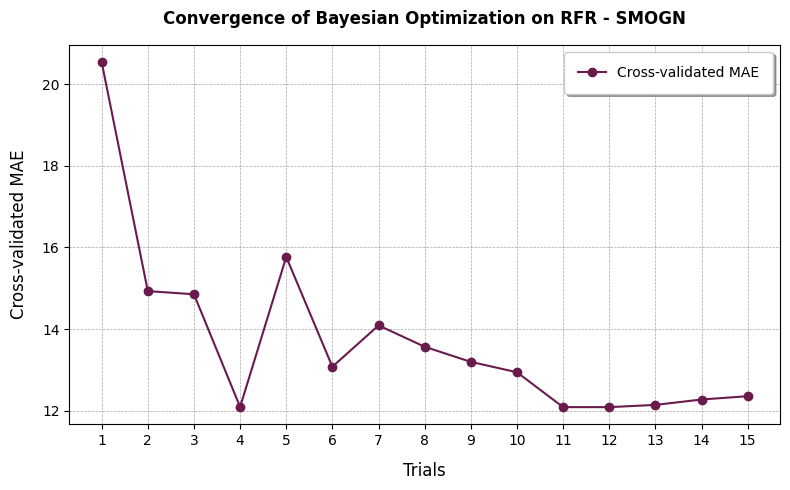

In [31]:
# Convergence Plot 


plt.figure(figsize=(8, 5))  

# Extract data from trials
trials = study.trials_dataframe()
plt.plot(
    trials.index, 
    trials['value'], 
    marker='o', 
    linestyle='-', 
    color='#6A1B4D', #burgundy
    label='Cross-validated MAE'
)

# Adding labels and title
plt.xlabel('Trials', fontsize=12, labelpad=10)  # Add padding for better spacing
plt.ylabel('Cross-validated MAE', fontsize=12, labelpad=10)
plt.title('Convergence of Bayesian Optimization on RFR - SMOGN', fontsize=12, pad=15, fontweight="bold")

# Ensure Trial Index is displayed as integers
plt.xticks(ticks=range(len(trials)), labels=range(1, len(trials) + 1))  # Trial indices start from 1

# Grid for better readability
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Adding a legend
plt.legend(fontsize=10, loc='best', frameon=True, shadow=True, borderpad=1)

# Improve layout and show the plot
plt.tight_layout()
plt.show()


In [32]:

# Initialize Random Forest Regressor with the best parameters
final_rfr_model = RandomForestRegressor(**best_params, random_state=42)

# Measure training time
start_time = time.time()
final_rfr_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Save the trained Random Forest Regressor model
rfr_imb_path = "rfr_smogn.pkl"
dump(final_rfr_model, rfr_imb_path)
print(f"Random Forest model saved successfully to {rfr_imb_path}!")

# to load the model (if needed)
# loaded_model = load(model_path)
# print("Model loaded successfully!")

# Predict on the training set and evaluate
y_train_pred = final_rfr_model.predict(X_train)
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred)) 
train_r2 = r2_score(y_train, y_train_pred)

print("\nTraining Set Results with Best Parameters:")
print("MAE:", train_mae)
print("RMSE:", train_rmse)
print("R²:", train_r2)
print("Training Time:", training_time, "seconds")

# Predict on the test set and evaluate
start_time = time.time()
y_pred_rfr = final_rfr_model.predict(X_test)
test_time = time.time() - start_time

pd.DataFrame(y_pred_rfr, columns=["y_pred_rfr"]).to_csv("rfr_smogn_predictions.csv", index=False) #saving rfr predicitons for ttest later

test_mae = mean_absolute_error(y_test, y_pred_rfr)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
test_r2 = r2_score(y_test, y_pred_rfr)

print("\nTest Set Results with Best Parameters:")
print("MAE:", test_mae)
print("RMSE:", test_rmse)
print("R²:", test_r2)
print("Test Evaluation Time:", test_time, "seconds")


Random Forest model saved successfully to rfr_smogn.pkl!

Training Set Results with Best Parameters:
MAE: 6.982066843012821
RMSE: 12.946565559829727
R²: 0.9091932560605054
Training Time: 413.07377791404724 seconds

Test Set Results with Best Parameters:
MAE: 17.34821615492378
RMSE: 25.741568602873553
R²: 0.5240367755561861
Test Evaluation Time: 1.9864051342010498 seconds


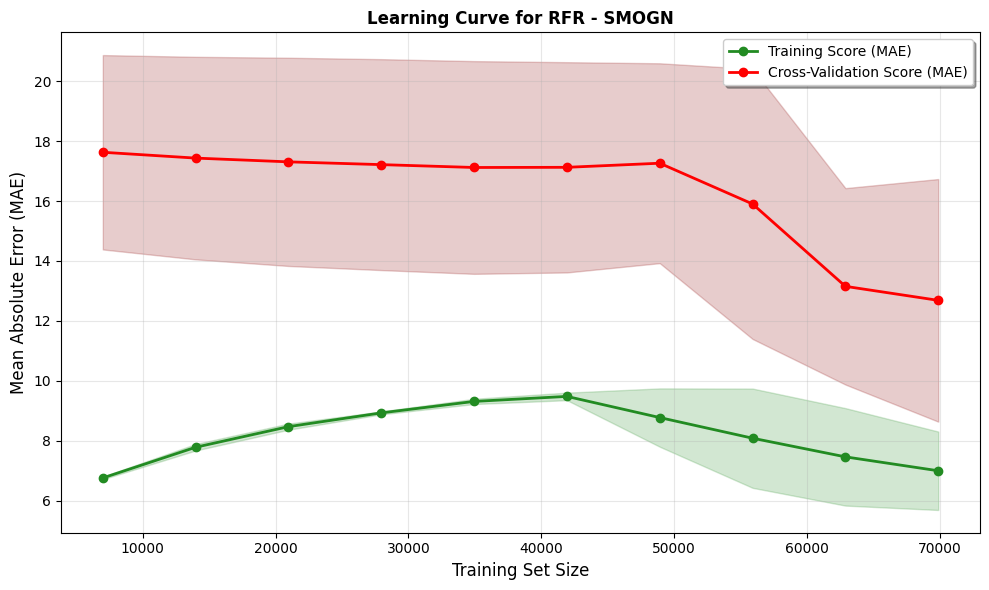

In [33]:
# Plot the learning curve

plt.figure(figsize=(10, 6))

# Plot training scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['train_scores_mean'], 
    'o-', color='#228B22', label="Training Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['train_scores_mean'] - learning_curve_data['train_scores_std'],
    learning_curve_data['train_scores_mean'] + learning_curve_data['train_scores_std'],
    alpha=0.2, color='#228B22'
)

# Plot cross-validation scores
plt.plot(
    learning_curve_data['train_sizes'], 
    learning_curve_data['cv_scores_mean'], 
    'o-', color='red', label="Cross-Validation Score (MAE)", linewidth=2, markersize=6
)
plt.fill_between(
    learning_curve_data['train_sizes'],
    learning_curve_data['cv_scores_mean'] - learning_curve_data['cv_scores_std'],
    learning_curve_data['cv_scores_mean'] + learning_curve_data['cv_scores_std'],
    alpha=0.2, color='#8B0000'
)

# Add labels, title, and legend
plt.xlabel("Training Set Size", fontsize=12)
plt.ylabel("Mean Absolute Error (MAE)", fontsize=12)
plt.title("Learning Curve for RFR - SMOGN", fontweight='bold')
plt.legend(loc="best", fontsize=10, frameon=True, shadow=True)
plt.grid(alpha=0.3)

# Improve spacing and add a professional touch
plt.tight_layout()
plt.show()


Binned MAE for GBR: [15.516426082224722, 63.943010438003185, 55.13692609766873, 56.88232252023551, 49.46685914943991, 37.1513380329517, 50.075235648529464, 33.9138379737455, 32.1085947078619, 31.722567128354395, 27.334406820967466, 29.478016009923433, 32.78223691963862, 28.8054517129952, 25.56753059568252, 21.08342634524582, 23.87043451209345, 18.44674861901414, 15.554098584406825, 17.79797451548366, 15.67346706142568, 12.616848207818236, 11.70013889508891, 11.991541056699235, 11.147195920907986, 9.452270610881467, 9.097648499598112, 11.560466324220199, 9.304086012856539, 11.249644348900876, 11.831085557664176, 11.463831726304843, 12.05461014179652, 13.357132250535974, 13.889224681217538, 13.870982635682799, 13.457007479020815]
Binned MAE for RFR: [14.919415542527378, 52.08690962734335, 55.77596680960064, 51.96704086230855, 49.418588396467726, 33.03264802426568, 48.51419234099579, 31.061584569216336, 32.50831114620254, 34.99342318951106, 24.41909469081517, 27.934490156033014, 31.958080

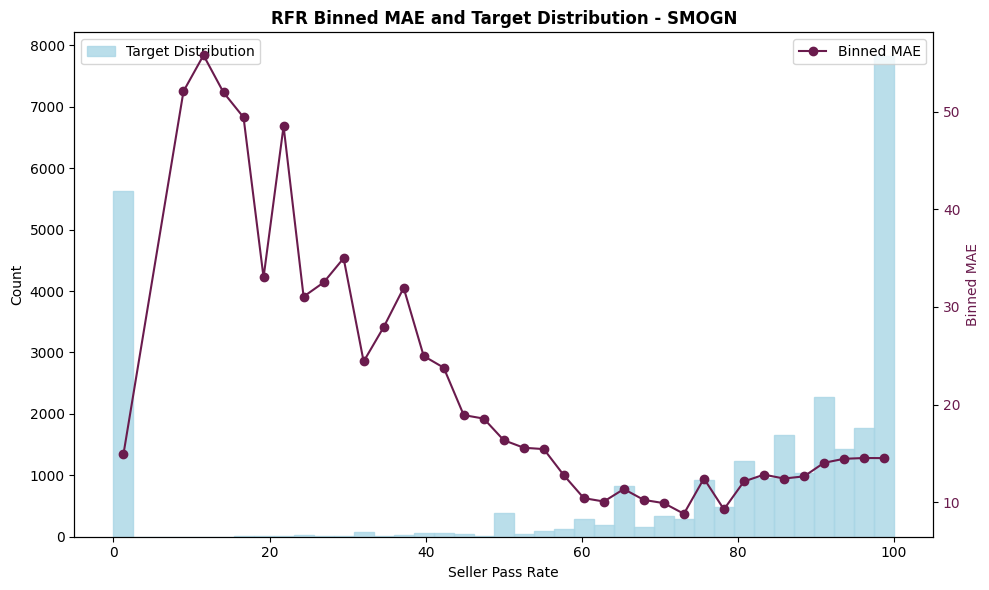

In [34]:
# target distribution binned mae

y_pred = y_pred_rfr 

# RFR Binned MAE Calculation
bin_indices_rfr = np.digitize(y_test, bins)  # Create bins for RFR
binned_mae_rfr = []
bin_centers_rfr = []

for i in range(1, len(bins)):
    mask = bin_indices_rfr == i
    if sum(mask) > 0:
        mae = np.mean(np.abs(y_test[mask] - y_pred_rfr[mask]))
        binned_mae_rfr.append(mae)
        bin_centers_rfr.append((bins[i - 1] + bins[i]) / 2)

# Print to Verify Results
print("Binned MAE for GBR:", binned_mae_gbr)
print("Binned MAE for RFR:", binned_mae_rfr)

# Plot RFR Binned MAE
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.hist(y_test, bins=bins, color="#A9D6E5", alpha=0.8, edgecolor="#A9D6E5", label="Target Distribution")
ax1.set_xlabel("Seller Pass Rate")
ax1.set_ylabel("Count")
ax1.tick_params(axis="y", labelcolor="black", )
ax1.set_title("RFR Binned MAE and Target Distribution - SMOGN", fontweight="bold")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(bin_centers_rfr, binned_mae_rfr, color="#6A1B4D", marker="o", linestyle="-", label="Binned MAE")
ax2.set_ylabel("Binned MAE", color="#6A1B4D")
ax2.tick_params(axis="y", labelcolor="#6A1B4D")
ax2.legend(loc="upper right")
plt.tight_layout()
plt.show()



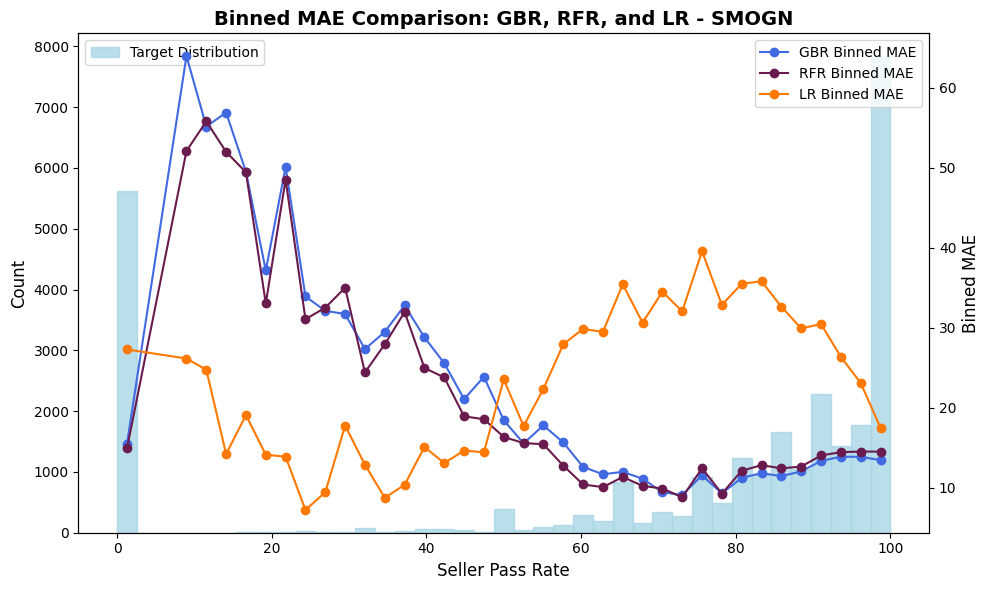

In [35]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot histogram for target distribution
ax1.hist(y_test, bins=bins, color="#A9D6E5", alpha=0.8, edgecolor="#A9D6E5", label="Target Distribution")
ax1.set_xlabel("Seller Pass Rate", fontsize=12)
ax1.set_ylabel("Count", fontsize=12, color="black")
ax1.tick_params(axis="y", labelcolor="black")
ax1.legend(loc="upper left", fontsize=10)

# Add secondary y-axis for Binned MAE
ax2 = ax1.twinx()

# Plot GBR Binned MAE
ax2.plot(bin_centers_gbr, binned_mae_gbr, color="#4169e1", marker="o", linestyle="-", label="GBR Binned MAE", linewidth=1.5)

# Plot RFR Binned MAE
ax2.plot(bin_centers_rfr, binned_mae_rfr, color="#6A1B4D", marker="o", linestyle="-", label="RFR Binned MAE", linewidth=1.5)

# Plot LR Binned MAE
ax2.plot(bin_centers_lr, binned_mae_lr, color="#FF7800", marker="o", linestyle="-", label="LR Binned MAE", linewidth=1.5)

# Set secondary y-axis properties
ax2.set_ylabel("Binned MAE", fontsize=12, color="black")
ax2.tick_params(axis="y", labelcolor="black")
ax2.legend(loc="upper right", fontsize=10)

# Title
plt.title("Binned MAE Comparison: GBR, RFR, and LR - SMOGN", fontsize=14, fontweight="bold")

# Adjust layout and show plot
plt.tight_layout()
plt.show()


Feature Importance and Insights

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns 

def plot_feature_importance(model, feature_names, model_name, top_n=10):
    """
    Plots the feature importance for a given model.
    
    Parameters:
    - model: Trained model (GBR or RFR)
    - feature_names: List of feature names
    - model_name: Name of the model (string)
    - top_n: Number of top features to display
    """
    # Extract feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for sorting and visualization
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False).head(top_n)
    
      # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=feature_importance_df, 
        x='Importance', 
        y='Feature', 
        color="#01386A", 
        linewidth=1,  # Reduces overall bar size visually
        dodge=False  # Ensures no overlapping
    )
    plt.title(f"Top {top_n} Most Predictive Features: {model_name}", fontweight="bold")
    plt.xlabel("Feature Importance")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.show()


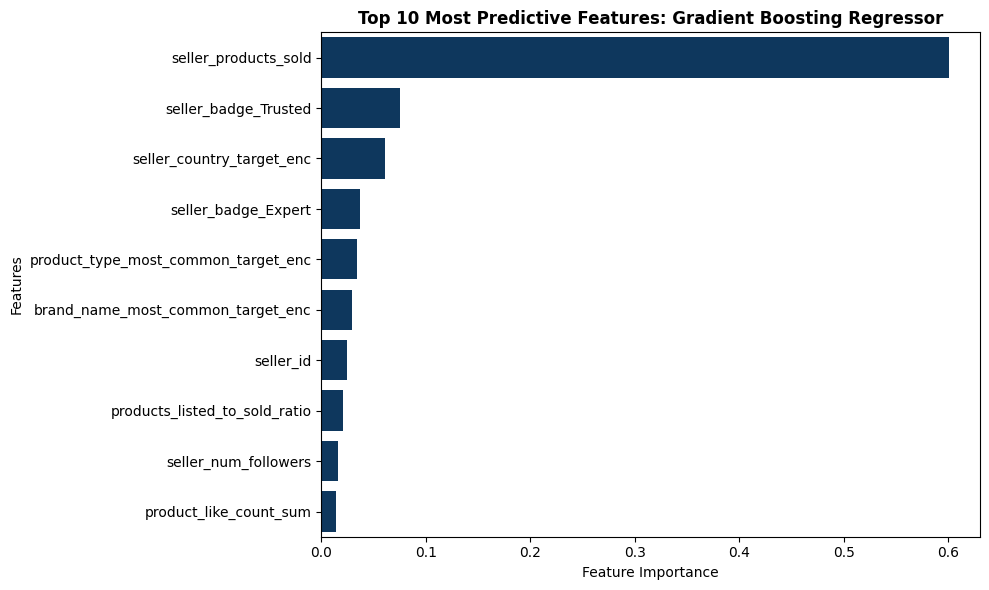

In [40]:
# Plot for GBR
plot_feature_importance(final_gbr_model, X_train.columns, "Gradient Boosting Regressor")

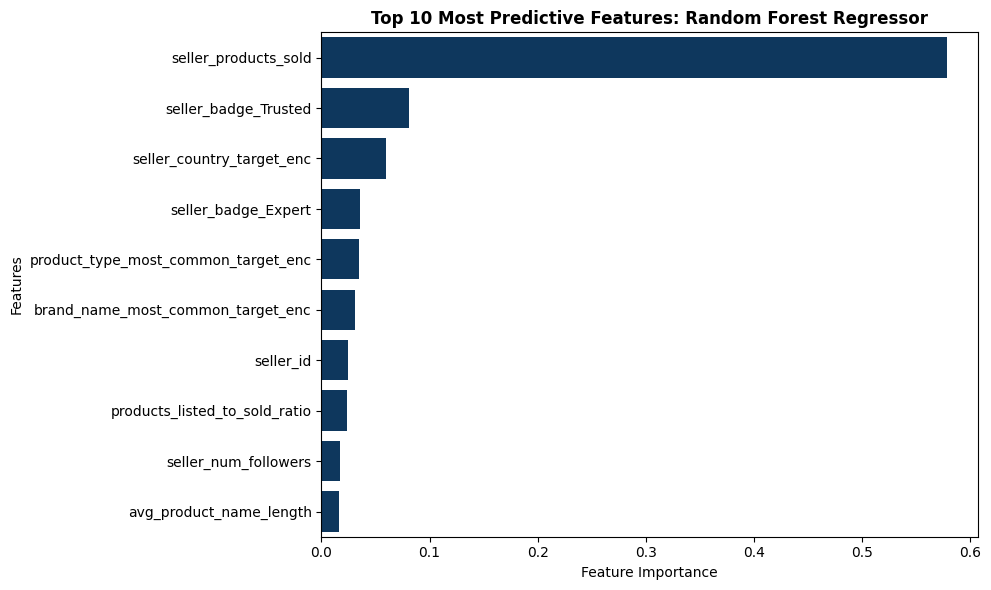

In [43]:
# Plot for RFR
plot_feature_importance(final_rfr_model, X_train.columns, "Random Forest Regressor")

Error Analysis

LR

/var/folders/py/w8w96dx57h53hf_ggjt2zdxh0000gn/T/ipykernel_2465/1425208922.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line


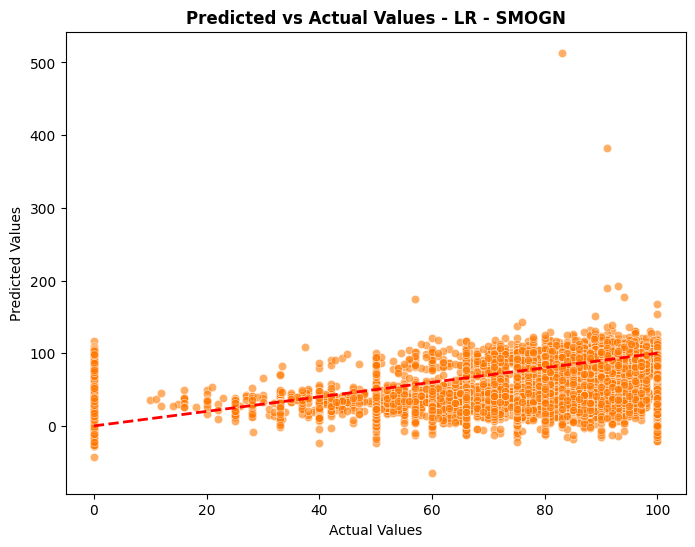

In [44]:
# Prediction vs Actual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.6, color='#FF7800')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line
plt.title("Predicted vs Actual Values - LR - SMOGN", fontweight="bold")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()


GBR

/var/folders/py/w8w96dx57h53hf_ggjt2zdxh0000gn/T/ipykernel_2465/3539725383.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line


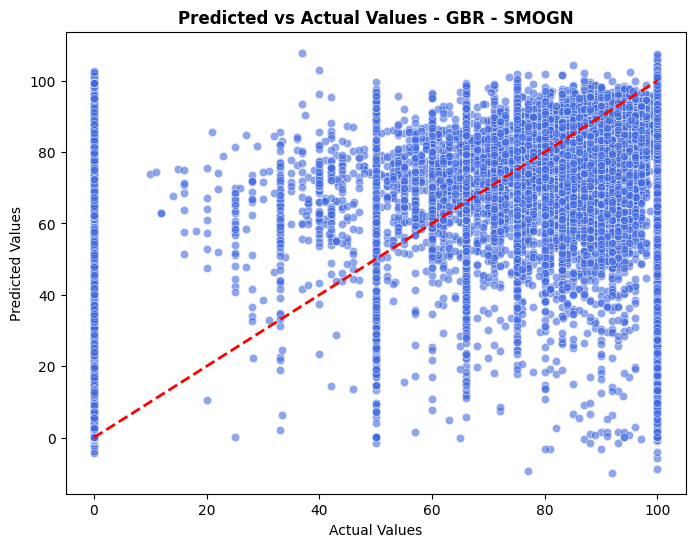

In [45]:
# Prediction vs Actual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_gbr, alpha=0.6, color='#4169e1') 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line
plt.title("Predicted vs Actual Values - GBR - SMOGN", fontweight="bold")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

RFR

/var/folders/py/w8w96dx57h53hf_ggjt2zdxh0000gn/T/ipykernel_2465/1618858291.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line


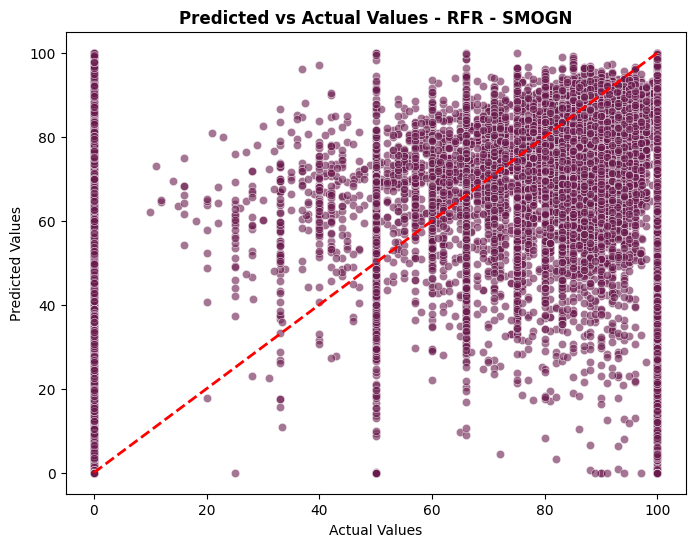

In [46]:
# Prediction vs Actual plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rfr, alpha=0.6, color='#6A1B4D')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', color='red', linewidth=2)  # Diagonal line
plt.title("Predicted vs Actual Values - RFR - SMOGN", fontweight="bold")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()